In [1]:
import torch

import torch.nn as nn

import torch.optim as optim

from torch.optim import lr_scheduler

import numpy as np

import torchvision

from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

import time

import os

import copy



mean = np.array([0.5, 0.5, 0.5])

std = np.array([0.25, 0.25, 0.25])



data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(224),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(224),

        transforms.ToTensor(),

        transforms.Normalize(mean, std)

    ]),

}

In [ ]:
data_dir = '/DATA/trainPhase1'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),

                                          data_transforms[x])

                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,

                                             shuffle=True, num_workers=0)

              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)





def imshow(inp, title):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    plt.title(title)

    plt.show()



['Obs', 'def', 'nor']


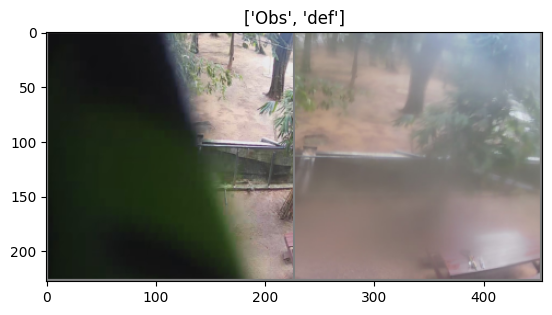

In [8]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))



# Make a grid from batch

out = torchvision.utils.make_grid(inputs)



imshow(out, title=[class_names[x] for x in classes])



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0



    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        print('-' * 10)



        # Each epoch has a training and validation phase

        for phase in ['train', 'val']:

            if phase == 'train':

                model.train()  # Set model to training mode

            else:

                model.eval()   # Set model to evaluate mode



            running_loss = 0.0

            running_corrects = 0



            # Iterate over data.

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)

                labels = labels.to(device)



                # forward

                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)



                    # backward + optimize only if in training phase

                    if phase == 'train':

                        optimizer.zero_grad()

                        loss.backward()

                        optimizer.step()



                # statistics

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == labels.data)



            if phase == 'train':

                scheduler.step()



            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]



            print('{} Loss: {:.4f} Acc: {:.4f}'.format(

                phase, epoch_loss, epoch_acc))
            
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)



            # deep copy the model

            if phase == 'val' and epoch_acc > best_acc:

                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)



        print()



    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(

        time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:4f}'.format(best_acc))



    # load best model weights

    model.load_state_dict(best_model_wts)

    return model



In [9]:
model = models.alexnet(pretrained=True)
print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
num_classes = 3  # number of classes 3

# Replace the final classifier 
model.classifier[6] = torch.nn.Linear(4096, num_classes)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.2741 Acc: 0.8909
val Loss: 0.3496 Acc: 0.8712

Epoch 1/29
----------
train Loss: 0.1517 Acc: 0.9437
val Loss: 0.5855 Acc: 0.8675

Epoch 2/29
----------
train Loss: 0.1142 Acc: 0.9553
val Loss: 0.5973 Acc: 0.8908

Epoch 3/29
----------
train Loss: 0.0994 Acc: 0.9650
val Loss: 0.5707 Acc: 0.8859

Epoch 4/29
----------
train Loss: 0.1018 Acc: 0.9634
val Loss: 0.4981 Acc: 0.9043

Epoch 5/29
----------
train Loss: 0.0807 Acc: 0.9721
val Loss: 0.6760 Acc: 0.8896

Epoch 6/29
----------
train Loss: 0.0885 Acc: 0.9711
val Loss: 0.6463 Acc: 0.8957

Epoch 7/29
----------
train Loss: 0.0586 Acc: 0.9811
val Loss: 0.6909 Acc: 0.9092

Epoch 8/29
----------
train Loss: 0.0536 Acc: 0.9842
val Loss: 0.7201 Acc: 0.9067

Epoch 9/29
----------
train Loss: 0.0542 Acc: 0.9847
val Loss: 0.7639 Acc: 0.9067

Epoch 10/29
----------
train Loss: 0.0411 Acc: 0.9866
val Loss: 0.7672 Acc: 0.9129

Epoch 11/29
----------
train Loss: 0.0452 Acc: 0.9855
val Loss: 0.8653 Acc: 0.8908

Ep

(0.8908756245069682, 0.8711656441717792, 0.9437286352879306, 0.8674846625766872, 0.9552984485932159, 0.89079754601227, 0.9650276097817513, 0.8858895705521473, 0.9634499079673942, 0.9042944785276075, 0.9721272679463582, 0.8895705521472393, 0.9710754667367868, 0.8957055214723927, 0.981067578227715, 0.9092024539877301, 0.9842229818564292, 0.9067484662576688, 0.9847488824612148, 0.9067484662576688, 0.9865895345779648, 0.9128834355828221, 0.9855377333683935, 0.89079754601227, 0.9847488824612148, 0.89079754601227, 0.9865895345779648, 0.9006134969325154, 0.9873783854851433, 0.8969325153374234, 0.9886931369971076, 0.9030674846625767, 0.9879042860899291, 0.9030674846625767, 0.9860636339731791, 0.8969325153374234, 0.9871154351827505, 0.8993865030674847, 0.982908230344465, 0.9067484662576688, 0.9850118327636077, 0.9030674846625767, 0.986326584275572, 0.901840490797546, 0.9907967394162503, 0.9030674846625767, 0.9884301866947147, 0.9030674846625767, 0.9855377333683935, 0.9042944785276075, 0.9852747

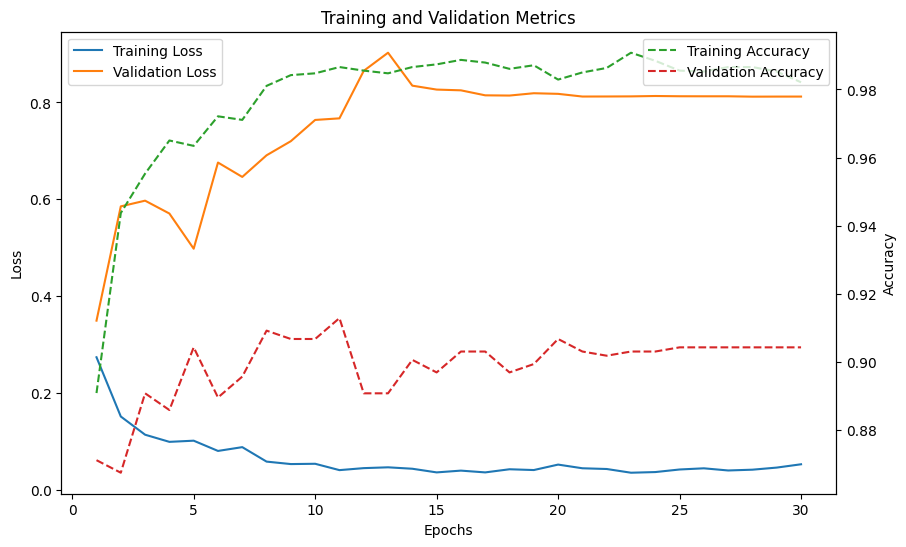

In [ ]:


tensor_tuple = train_acc

# Extract the first element of each tensor in the tuple
float_tuple = tuple(tensor.item() for tensor in tensor_tuple)

# Print the float tuple
print(float_tuple)


def separate_even_odd_indexes(float_tuple):
  train_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 == 0)
  valid_accuracy = tuple(ele for idx, ele in enumerate(float_tuple) if idx % 2 != 0)
  return train_accuracy, valid_accuracy

#test_tup 
train_accuracyy, valid_accuracyy = separate_even_odd_indexes(float_tuple)


#Losses
def separate_even_odd_indexes(train_loss):
  trainig_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 == 0)
  val_loss = tuple(ele for idx, ele in enumerate(train_loss) if idx % 2 != 0)
  return trainig_loss, val_loss

#test_tup 
trainig_loss, val_loss = separate_even_odd_indexes(train_loss)

print(trainig_loss)
print(val_loss)

import matplotlib.pyplot as plt




# Sample data 

epochs = [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

train_losses = trainig_loss

val_losses = val_loss

train_accuracies = train_accuracyy

val_accuracies = valid_accuracyy



fig, ax1 = plt.subplots(figsize=(10, 6))




ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')

ax1.plot(epochs, val_losses, label='Validation Loss', color='tab:orange')

ax1.set_xlabel('Epochs')

ax1.set_ylabel('Loss', color='black')

ax1.tick_params(axis='y', labelcolor='black')

ax1.legend(loc='upper left')





ax2 = ax1.twinx()





ax2.plot(epochs, train_accuracies, label='Training Accuracy', linestyle='--', color='tab:green')

ax2.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', color='tab:red')

ax2.set_ylabel('Accuracy', color='black')

ax2.tick_params(axis='y', labelcolor='black')

ax2.legend(loc='upper right')



plt.title('Training and Validation Metrics')

plt.xlabel('Epochs')



# Show the combined plot

plt.show()



In [ ]:
# Saving PyTorch model

torch.save(model.state_dict(), 'alexnet.pth')

torch.save(optimizer.state_dict(), "alexnetoptim.pth")

increasing val data to 13000